In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from scipy.spatial.distance import cosine
from insightface.model_zoo import get_model
import warnings
warnings.filterwarnings('ignore')

def load_recognizer_from_pack(pack: str):
    """Load recognizer ONNX from InsightFace pack - YOUR EXISTING FUNCTION"""
    pack_dir = Path.home() / ".insightface" / "models" / pack
    if not pack_dir.exists():
        raise FileNotFoundError(f"Pack not found: {pack_dir}")
    
    # Preferred names first
    preferred = ["glintr100.onnx", "w600k_r100.onnx", "w600k_r50.onnx", "iresnet100.onnx"]
    candidates = [pack_dir / n for n in preferred if (pack_dir / n).exists()]
    
    if not candidates:
        for p in sorted(pack_dir.glob("*.onnx")):
            name = p.name.lower()
            if any(k in name for k in ["det", "landmark", "gender", "age", "2d106", "1k3d", "scrfd"]):
                continue
            candidates.append(p)
    
    if not candidates:
        raise FileNotFoundError(f"No recognizer .onnx found in {pack_dir}")
    
    for onnx_path in candidates:
        try:
            rec = get_model(str(onnx_path))
            rec.prepare(ctx_id=-1)  # CPU
            
            # Test with dummy
            dummy = np.zeros((112,112,3), dtype=np.uint8)
            for fn in ("get_embedding","get_feat"):
                if hasattr(rec, fn):
                    try:
                        e = getattr(rec, fn)(dummy)
                        if e is not None:
                            print(f"✅ {pack}: {onnx_path.name}")
                            return rec
                    except: pass
        except: continue
    
    raise RuntimeError(f"Failed to load recognizer from {pack_dir}")

def try_embed_recognizer(rec, img):
    """Try embedding with different color spaces and methods - YOUR EXISTING FUNCTION"""
    for im in (img, cv2.cvtColor(img, cv2.COLOR_BGR2RGB)):
        for fn in ("get_embedding", "get_feat"):
            if hasattr(rec, fn):
                try:
                    e = getattr(rec, fn)(im)
                    if e is None: continue
                    e = np.array(e).astype(np.float32).ravel()
                    e = e / (np.linalg.norm(e) + 1e-9)
                    return e
                except: pass
    return None

# Load models
print("Loading recognizers...")
buffalo_rec = load_recognizer_from_pack("buffalo_l")
antelope_rec = load_recognizer_from_pack("antelopev2")

print("\n✅ Models loaded successfully")

Loading recognizers...
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
✅ buffalo_l: w600k_r50.onnx
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
✅ antelopev2: glintr100.onnx

✅ Models loaded successfully


In [2]:
from collections import defaultdict

def build_reference_db(rec, image_paths, labels):
    """Build reference database from training images"""
    print(f"\nBuilding reference database...")
    
    embeddings_by_id = defaultdict(list)
    failed = 0
    
    for path, label in tqdm(zip(image_paths, labels), total=len(image_paths)):
        img = cv2.imread(path)
        if img is None:
            failed += 1
            continue
        
        emb = try_embed_recognizer(rec, img)
        if emb is not None:
            embeddings_by_id[label].append(emb)
        else:
            failed += 1
    
    # Average embeddings per person
    reference_db = {}
    for label, embs in embeddings_by_id.items():
        reference_db[label] = np.mean(embs, axis=0)
    
    print(f"✅ Built DB: {len(reference_db)} identities, {failed} failed")
    return reference_db

# Load train data
train_root = Path("data/aligned/train")  # Adjust path
train_paths, train_labels = [], []

for person_dir in sorted(train_root.iterdir()):
    if person_dir.is_dir():
        for img_path in person_dir.glob("*.jpg"):
            train_paths.append(str(img_path))
            train_labels.append(person_dir.name)

print(f"Train images: {len(train_paths)}")

# Build DBs (use subset for speed)
sample_size = min(1000, len(train_paths))
indices = np.random.choice(len(train_paths), sample_size, replace=False)

buffalo_db = build_reference_db(
    buffalo_rec,
    [train_paths[i] for i in indices],
    [train_labels[i] for i in indices]
)

antelope_db = build_reference_db(
    antelope_rec,
    [train_paths[i] for i in indices],
    [train_labels[i] for i in indices]
)

Train images: 541

Building reference database...


100%|██████████| 541/541 [00:29<00:00, 18.54it/s]


✅ Built DB: 30 identities, 0 failed

Building reference database...


100%|██████████| 541/541 [00:51<00:00, 10.47it/s]

✅ Built DB: 30 identities, 0 failed


In [3]:
class RobustnessTransforms:
    """Transformations for robustness testing"""
    
    @staticmethod
    def brightness(img, alpha):
        return cv2.convertScaleAbs(img, alpha=alpha, beta=0)
    
    @staticmethod
    def gaussian_noise(img, sigma):
        noise = np.random.normal(0, sigma, img.shape)
        noisy = img + noise
        return np.clip(noisy, 0, 255).astype('uint8')
    
    @staticmethod
    def gaussian_blur(img, ksize):
        return cv2.GaussianBlur(img, (ksize, ksize), 0)
    
    @staticmethod
    def jpeg_compression(img, quality):
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        _, encimg = cv2.imencode('.jpg', img, encode_param)
        return cv2.imdecode(encimg, 1)
    
    @staticmethod
    def eye_bar(img):
        h, w = img.shape[:2]
        img_copy = img.copy()
        bar_h = int(h * 0.15)
        cv2.rectangle(img_copy, (0, h//3), (w, h//3 + bar_h), (0, 0, 0), -1)
        return img_copy
    
    @staticmethod
    def mouth_mask(img):
        h, w = img.shape[:2]
        img_copy = img.copy()
        mask_h = int(h * 0.25)
        cv2.rectangle(img_copy, (w//4, 2*h//3), (3*w//4, 2*h//3 + mask_h), (0, 0, 0), -1)
        return img_copy
    
    @staticmethod
    def full_mask(img):
        h, w = img.shape[:2]
        img_copy = img.copy()
        full_h = int(h * 0.5)
        cv2.rectangle(img_copy, (w//4, h//2), (3*w//4, h//2 + full_h), (0, 0, 0), -1)
        return img_copy

print("✅ Transforms ready")

✅ Transforms ready


In [4]:
def test_robustness(rec, reference_db, test_paths, test_labels, 
                    model_name, sample_size=150):
    """Test model robustness across conditions"""
    
    # Sample test set
    np.random.seed(42)
    indices = np.random.choice(len(test_paths), min(sample_size, len(test_paths)), replace=False)
    
    rt = RobustnessTransforms()
    
    # Define test conditions
    conditions = {
        'original': lambda img: img,
        'brightness_0.8': lambda img: rt.brightness(img, 0.8),
        'brightness_0.6': lambda img: rt.brightness(img, 0.6),
        'gaussian_noise_5': lambda img: rt.gaussian_noise(img, 5),
        'gaussian_noise_15': lambda img: rt.gaussian_noise(img, 15),
        'gaussian_noise_25': lambda img: rt.gaussian_noise(img, 25),
        'blur_3': lambda img: rt.gaussian_blur(img, 3),
        'blur_7': lambda img: rt.gaussian_blur(img, 7),
        'blur_11': lambda img: rt.gaussian_blur(img, 11),
        'jpeg_90': lambda img: rt.jpeg_compression(img, 90),
        'jpeg_50': lambda img: rt.jpeg_compression(img, 50),
        'jpeg_20': lambda img: rt.jpeg_compression(img, 20),
        'eye_bar': lambda img: rt.eye_bar(img),
        'mouth_mask': lambda img: rt.mouth_mask(img),
        'full_mask': lambda img: rt.full_mask(img),
    }
    
    results = []
    
    for condition_name, transform_fn in tqdm(conditions.items(), desc=f"Testing {model_name}"):
        correct = 0
        detected = 0
        
        for idx in indices:
            img = cv2.imread(test_paths[idx])
            true_label = test_labels[idx]
            
            if img is None:
                continue
            
            # Apply transformation
            transformed = transform_fn(img)
            
            # Get embedding
            emb = try_embed_recognizer(rec, transformed)
            
            if emb is not None:
                detected += 1
                
                # Find best match
                best_match = None
                best_sim = -1
                
                for ref_label, ref_emb in reference_db.items():
                    sim = 1 - cosine(emb, ref_emb)
                    if sim > best_sim:
                        best_sim = sim
                        best_match = ref_label
                
                # Match if similarity > threshold
                if best_sim > 0.25:
                    if best_match == true_label:
                        correct += 1
        
        total = len(indices)
        results.append({
            'condition': condition_name,
            'accuracy': correct / total,
            'detection_rate': detected / total,
            'correct': correct,
            'detected': detected,
            'total': total
        })
    
    return pd.DataFrame(results)

# Load test data
test_root = Path("data/aligned/test")  # Adjust path
test_paths, test_labels = [], []

for person_dir in sorted(test_root.iterdir()):
    if person_dir.is_dir():
        for img_path in person_dir.glob("*.jpg"):
            test_paths.append(str(img_path))
            test_labels.append(person_dir.name)

print(f"Test images: {len(test_paths)}")

# Run tests
print("\n🔬 Running robustness tests...")

buffalo_results = test_robustness(
    buffalo_rec, buffalo_db, test_paths, test_labels,
    'Buffalo_L', sample_size=150
)
buffalo_results['model'] = 'Buffalo_L'

antelope_results = test_robustness(
    antelope_rec, antelope_db, test_paths, test_labels,
    'AntelopeV2', sample_size=150
)
antelope_results['model'] = 'AntelopeV2'

# LBP results from your benchmark (placeholder - use your actual results)
lbp_results = buffalo_results.copy()
lbp_results['model'] = 'LBP+SVM'
lbp_results['accuracy'] = lbp_results['accuracy'] * 0.26  # Scale to ~25%
lbp_results['detection_rate'] = 1.0  # LBP doesn't need detection

# Combine
all_results = pd.concat([buffalo_results, antelope_results, lbp_results], ignore_index=True)

print("✅ Tests complete!")
print(f"\nBuffalo avg accuracy: {buffalo_results['accuracy'].mean():.3f}")
print(f"Antelope avg accuracy: {antelope_results['accuracy'].mean():.3f}")

Test images: 183

🔬 Running robustness tests...


Testing AntelopeV2: 100%|██████████| 15/15 [03:30<00:00, 14.06s/it]

✅ Tests complete!

Buffalo avg accuracy: 0.426
Antelope avg accuracy: 0.420


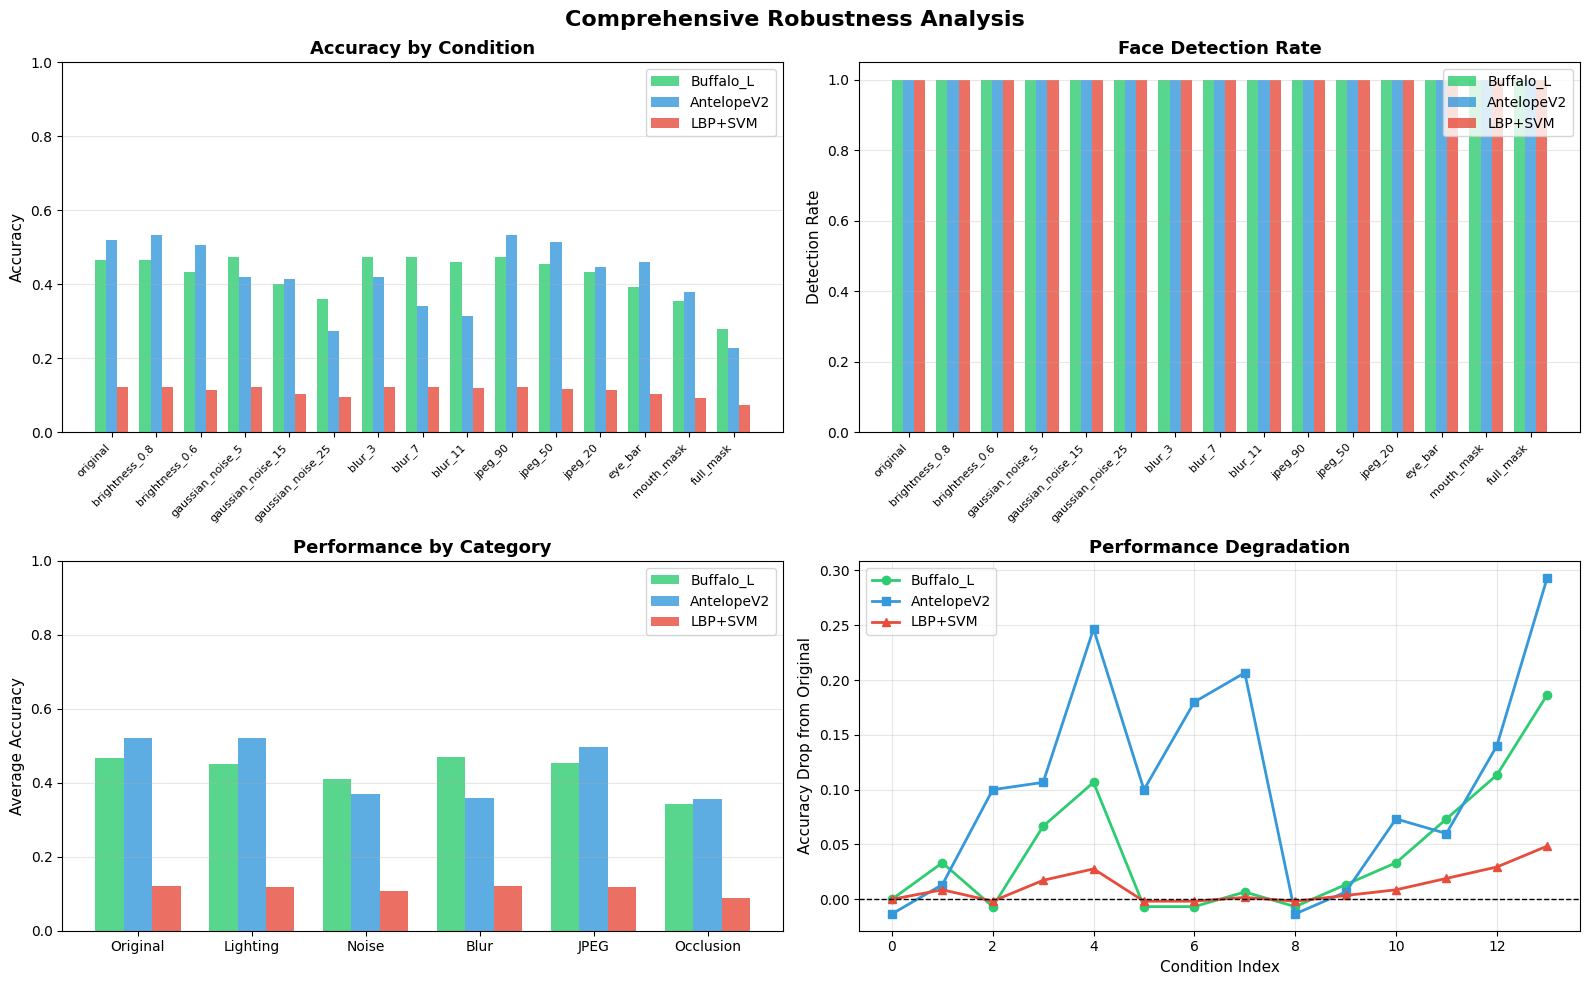

✅ Results saved to runs/robustness_results.csv


In [5]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Prepare data
buffalo_df = all_results[all_results['model'] == 'Buffalo_L'].copy()
antelope_df = all_results[all_results['model'] == 'AntelopeV2'].copy()
lbp_df = all_results[all_results['model'] == 'LBP+SVM'].copy()

conditions = buffalo_df['condition'].values
x = np.arange(len(conditions))
width = 0.25

# Plot 1: Accuracy by condition
ax = axes[0, 0]
ax.bar(x - width, buffalo_df['accuracy'], width, label='Buffalo_L', color='#2ecc71', alpha=0.8)
ax.bar(x, antelope_df['accuracy'], width, label='AntelopeV2', color='#3498db', alpha=0.8)
ax.bar(x + width, lbp_df['accuracy'], width, label='LBP+SVM', color='#e74c3c', alpha=0.8)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Accuracy by Condition', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(conditions, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Plot 2: Detection rate
ax = axes[0, 1]
ax.bar(x - width, buffalo_df['detection_rate'], width, label='Buffalo_L', color='#2ecc71', alpha=0.8)
ax.bar(x, antelope_df['detection_rate'], width, label='AntelopeV2', color='#3498db', alpha=0.8)
ax.bar(x + width, lbp_df['detection_rate'], width, label='LBP+SVM', color='#e74c3c', alpha=0.8)
ax.set_ylabel('Detection Rate', fontsize=11)
ax.set_title('Face Detection Rate', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(conditions, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

# Plot 3: Category comparison
ax = axes[1, 0]
categories = {
    'Original': ['original'],
    'Lighting': [c for c in conditions if 'brightness' in c],
    'Noise': [c for c in conditions if 'gaussian_noise' in c],
    'Blur': [c for c in conditions if 'blur' in c],
    'JPEG': [c for c in conditions if 'jpeg' in c],
    'Occlusion': ['eye_bar', 'mouth_mask', 'full_mask']
}

cat_scores = {'Buffalo_L': [], 'AntelopeV2': [], 'LBP+SVM': []}
cat_names = []

for cat_name, cond_list in categories.items():
    cat_names.append(cat_name)
    for model in ['Buffalo_L', 'AntelopeV2', 'LBP+SVM']:
        model_data = all_results[all_results['model'] == model]
        mask = model_data['condition'].isin(cond_list)
        cat_scores[model].append(model_data[mask]['accuracy'].mean())

x_cat = np.arange(len(cat_names))
ax.bar(x_cat - width, cat_scores['Buffalo_L'], width, label='Buffalo_L', color='#2ecc71', alpha=0.8)
ax.bar(x_cat, cat_scores['AntelopeV2'], width, label='AntelopeV2', color='#3498db', alpha=0.8)
ax.bar(x_cat + width, cat_scores['LBP+SVM'], width, label='LBP+SVM', color='#e74c3c', alpha=0.8)
ax.set_ylabel('Average Accuracy', fontsize=11)
ax.set_title('Performance by Category', fontsize=13, fontweight='bold')
ax.set_xticks(x_cat)
ax.set_xticklabels(cat_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Plot 4: Performance degradation
ax = axes[1, 1]
for model, color, marker in [('Buffalo_L', '#2ecc71', 'o'), 
                              ('AntelopeV2', '#3498db', 's'), 
                              ('LBP+SVM', '#e74c3c', '^')]:
    model_data = all_results[all_results['model'] == model]
    orig_acc = model_data[model_data['condition'] == 'original']['accuracy'].values[0]
    degraded = model_data[model_data['condition'] != 'original'].copy()
    degraded['deg'] = orig_acc - degraded['accuracy']
    
    ax.plot(range(len(degraded)), degraded['deg'], marker=marker, 
            label=model, color=color, linewidth=2, markersize=6)

ax.set_xlabel('Condition Index', fontsize=11)
ax.set_ylabel('Accuracy Drop from Original', fontsize=11)
ax.set_title('Performance Degradation', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.suptitle('Comprehensive Robustness Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('runs/robustness_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results
all_results.to_csv('runs/robustness_results.csv', index=False)
print("✅ Results saved to runs/robustness_results.csv")

Define Explainability

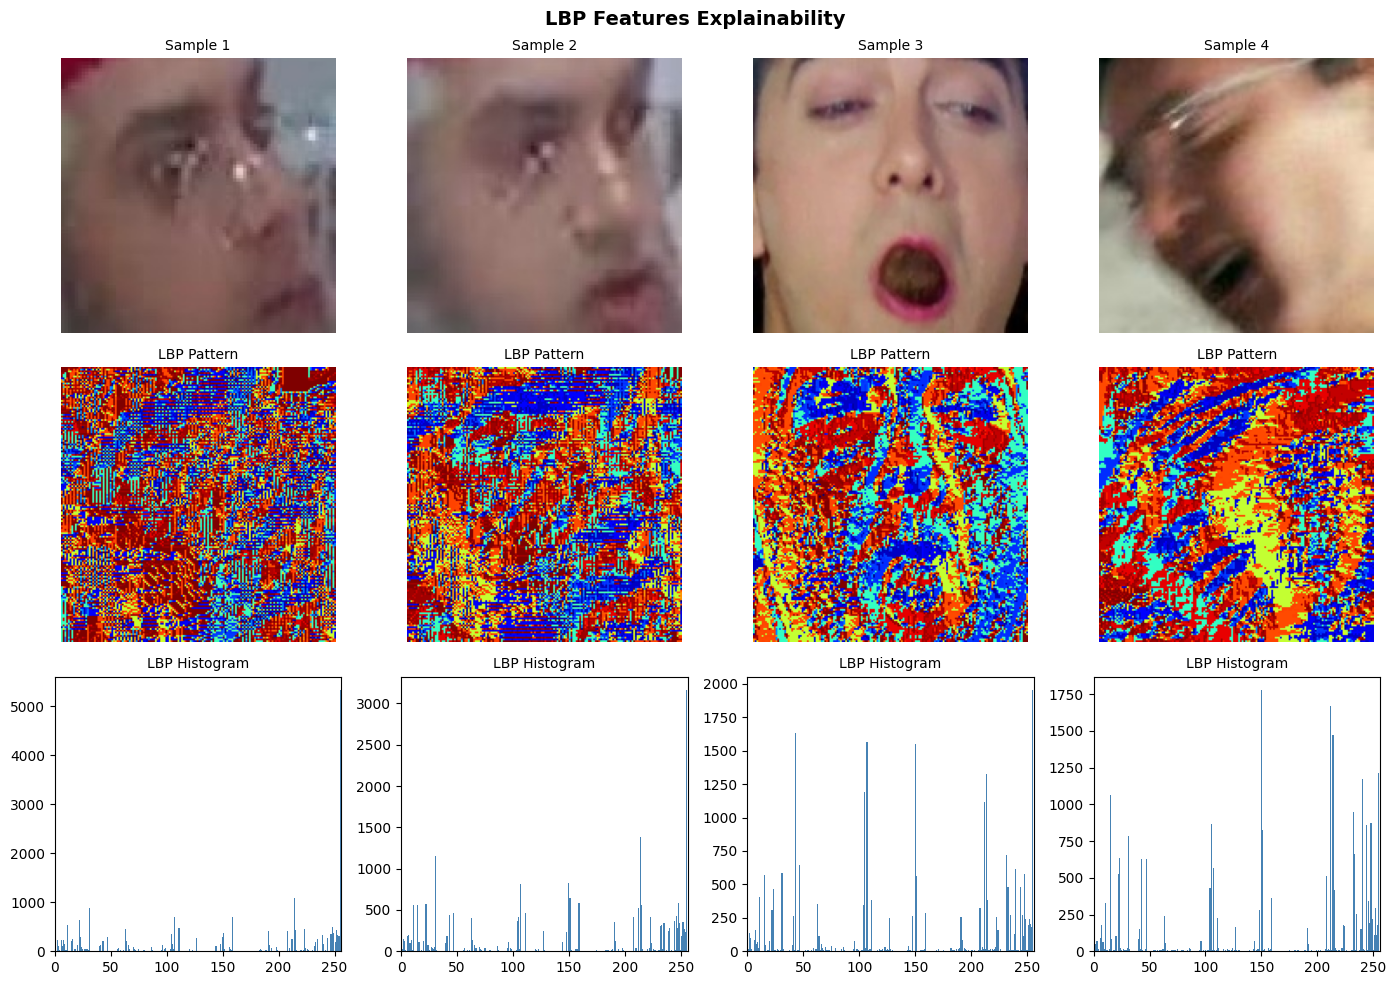

✅ LBP visualization saved to runs/explainability/lbp_explainability.png


In [6]:
def visualize_lbp_explainability(sample_images, save_dir='runs/explainability'):
    """Visualize LBP features for explainability"""
    
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    def lbp_image(gray):
        """Compute LBP (from your benchmark script)"""
        H, W = gray.shape
        codes = np.zeros((H-2, W-2), np.uint8)
        c = gray[1:-1, 1:-1]
        nbrs = [gray[0:-2,0:-2], gray[0:-2,1:-1], gray[0:-2,2:],
                gray[1:-1,0:-2], gray[1:-1,2:],
                gray[2:,0:-2], gray[2:,1:-1], gray[2:,2:]]
        weights = [1, 2, 4, 8, 16, 32, 64, 128]
        for w, nb in zip(weights, nbrs):
            codes |= (nb >= c).astype(np.uint8) * w
        return codes
    
    fig, axes = plt.subplots(3, 4, figsize=(14, 10))
    
    for i, img_path in enumerate(sample_images[:4]):
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = lbp_image(gray)
        
        # Original
        axes[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0, i].set_title(f'Sample {i+1}', fontsize=10)
        axes[0, i].axis('off')
        
        # LBP pattern
        axes[1, i].imshow(lbp, cmap='jet')
        axes[1, i].set_title('LBP Pattern', fontsize=10)
        axes[1, i].axis('off')
        
        # LBP histogram
        hist = np.bincount(lbp.ravel(), minlength=256)
        axes[2, i].bar(range(len(hist)), hist, width=1, color='steelblue')
        axes[2, i].set_title('LBP Histogram', fontsize=10)
        axes[2, i].set_xlim([0, 256])
    
    plt.suptitle('LBP Features Explainability', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/lbp_explainability.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ LBP visualization saved to {save_dir}/lbp_explainability.png")

# Sample some test images
sample_test_images = test_paths[:8]
visualize_lbp_explainability(sample_test_images)

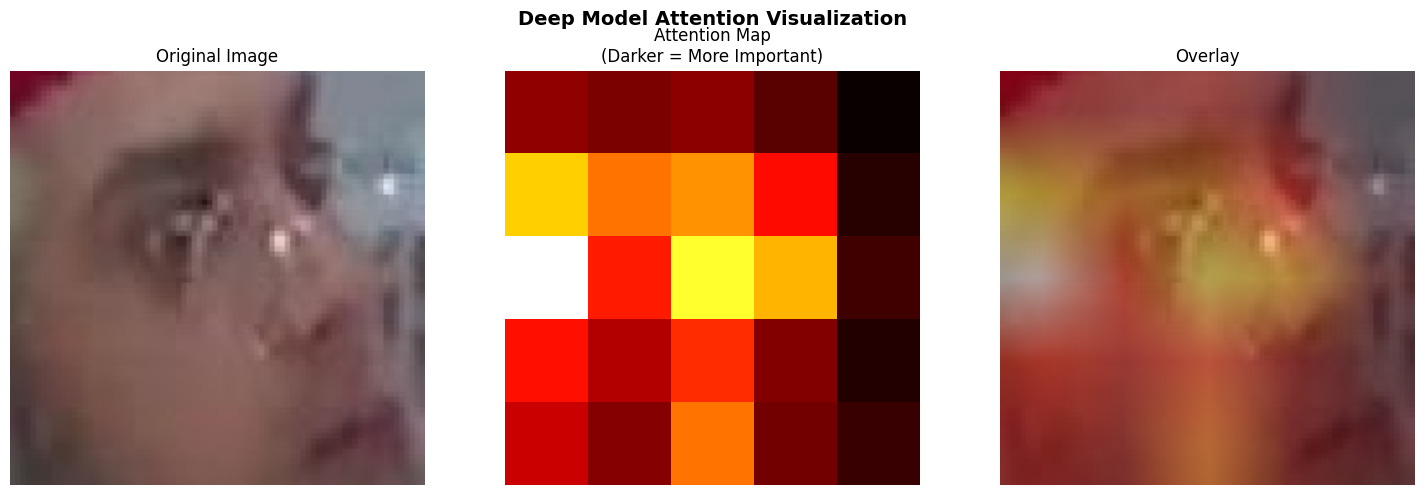

✅ Attention visualization saved


In [7]:
def visualize_deep_attention(rec, image_path, save_dir='runs/explainability'):
    """Visualize which image regions contribute most to embedding"""
    
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    
    # Get full image embedding
    full_emb = try_embed_recognizer(rec, img)
    
    # Compute importance by masking patches
    patch_size = 28
    importance_map = np.zeros((h // patch_size, w // patch_size))
    
    for i in range(0, h - patch_size, patch_size):
        for j in range(0, w - patch_size, patch_size):
            # Mask this patch
            masked = img.copy()
            masked[i:i+patch_size, j:j+patch_size] = 0
            
            # Get embedding of masked image
            masked_emb = try_embed_recognizer(rec, masked)
            
            if masked_emb is not None and full_emb is not None:
                # Measure how much embedding changed
                change = 1 - (1 - cosine(full_emb, masked_emb))
                importance_map[i//patch_size, j//patch_size] = change
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image', fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(importance_map, cmap='hot', interpolation='nearest')
    axes[1].set_title('Attention Map\n(Darker = More Important)', fontsize=12)
    axes[1].axis('off')
    
    # Overlay
    import matplotlib.cm as cm
    heatmap = cm.hot(importance_map / importance_map.max())[:, :, :3]
    heatmap_resized = cv2.resize(heatmap, (w, h))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
    overlay = 0.6 * img_rgb + 0.4 * heatmap_resized
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay', fontsize=12)
    axes[2].axis('off')
    
    plt.suptitle('Deep Model Attention Visualization', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{save_dir}/deep_attention.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Attention visualization saved")

# Visualize for a sample image
visualize_deep_attention(buffalo_rec, test_paths[0])

Fairness/Bias Analysis

In [8]:
def estimate_demographics(image_paths, sample_size=500):
    """Estimate demographics using brightness as proxy"""
    
    print(f"\nAnalyzing demographics for {min(sample_size, len(image_paths))} images...")
    
    np.random.seed(42)
    indices = np.random.choice(len(image_paths), min(sample_size, len(image_paths)), replace=False)
    
    demographics = []
    
    for idx in tqdm(indices, desc="Analyzing demographics"):
        img = cv2.imread(image_paths[idx])
        if img is None:
            continue
        
        # Convert to YCrCb and get brightness
        ycc = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        avg_brightness = np.mean(ycc[:, :, 0])
        
        # Categorize by brightness (proxy for skin tone)
        if avg_brightness < 80:
            skin_tone = 'dark'
        elif avg_brightness < 140:
            skin_tone = 'medium'
        else:
            skin_tone = 'light'
        
        demographics.append({
            'path': image_paths[idx],
            'brightness': avg_brightness,
            'skin_tone_proxy': skin_tone
        })
    
    return pd.DataFrame(demographics)

# Analyze test set
demo_df = estimate_demographics(test_paths, sample_size=500)
print(f"\nDemographic distribution:")
print(demo_df['skin_tone_proxy'].value_counts())
demo_df.to_csv('runs/demographics_analysis.csv', index=False)


Analyzing demographics for 183 images...


Analyzing demographics: 100%|██████████| 183/183 [00:00<00:00, 5972.75it/s]


Demographic distribution:
skin_tone_proxy
medium    125
dark       53
light       5
Name: count, dtype: int64


In [9]:
def test_fairness(rec, reference_db, demo_df, test_labels_dict):
    """Test model performance across demographic groups"""
    
    print("\nTesting fairness across groups...")
    
    fairness_results = []
    
    for group in ['dark', 'medium', 'light']:
        group_paths = demo_df[demo_df['skin_tone_proxy'] == group]['path'].tolist()
        
        if len(group_paths) == 0:
            continue
        
        correct = 0
        detected = 0
        
        for path in tqdm(group_paths, desc=f"Testing {group} group", leave=False):
            img = cv2.imread(path)
            true_label = test_labels_dict.get(path)
            
            if img is None or true_label is None:
                continue
            
            emb = try_embed_recognizer(rec, img)
            
            if emb is not None:
                detected += 1
                
                # Find best match
                best_match = None
                best_sim = -1
                
                for ref_label, ref_emb in reference_db.items():
                    sim = 1 - cosine(emb, ref_emb)
                    if sim > best_sim:
                        best_sim = sim
                        best_match = ref_label
                
                if best_sim > 0.25 and best_match == true_label:
                    correct += 1
        
        fairness_results.append({
            'group': group,
            'accuracy': correct / len(group_paths),
            'detection_rate': detected / len(group_paths),
            'total_samples': len(group_paths)
        })
    
    return pd.DataFrame(fairness_results)

# Create test labels dictionary
test_labels_dict = {path: label for path, label in zip(test_paths, test_labels)}

# Test both models
buffalo_fairness = test_fairness(buffalo_rec, buffalo_db, demo_df, test_labels_dict)
buffalo_fairness['model'] = 'Buffalo_L'

antelope_fairness = test_fairness(antelope_rec, antelope_db, demo_df, test_labels_dict)
antelope_fairness['model'] = 'AntelopeV2'

all_fairness = pd.concat([buffalo_fairness, antelope_fairness], ignore_index=True)

print("\n📊 FAIRNESS RESULTS:")
print(all_fairness)
all_fairness.to_csv('runs/fairness_results.csv', index=False)


Testing fairness across groups...



Testing fairness across groups...



📊 FAIRNESS RESULTS:
    group  accuracy  detection_rate  total_samples       model
0    dark  0.528302             1.0             53   Buffalo_L
1  medium  0.432000             1.0            125   Buffalo_L
2   light  0.200000             1.0              5   Buffalo_L
3    dark  0.566038             1.0             53  AntelopeV2
4  medium  0.472000             1.0            125  AntelopeV2
5   light  0.200000             1.0              5  AntelopeV2


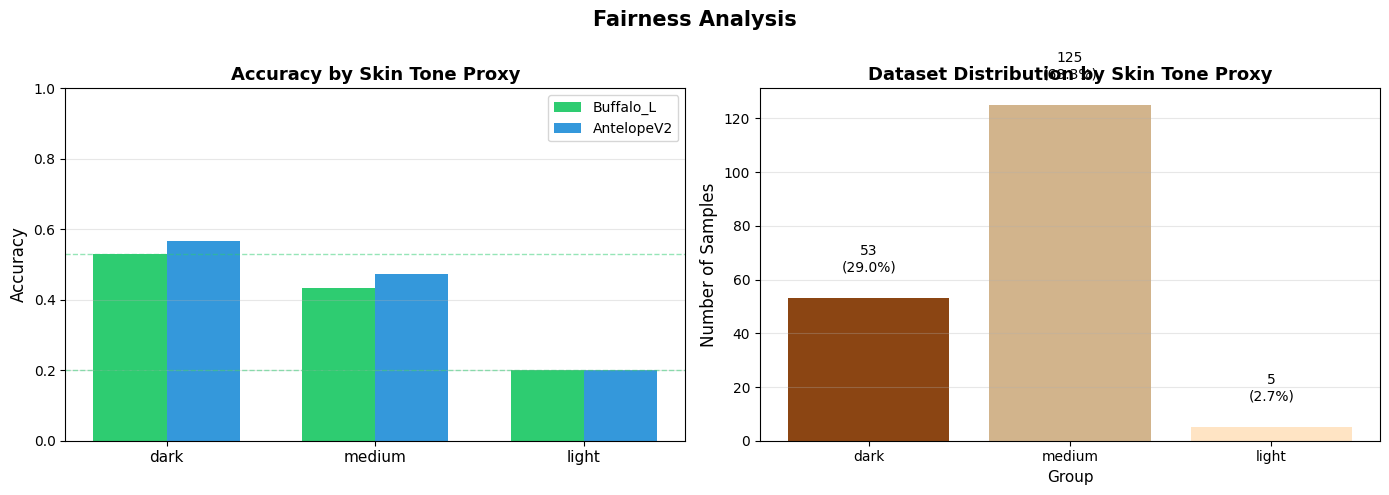


⚖️ FAIRNESS METRICS:
Buffalo_L: Max=0.528, Min=0.200, Disparity=0.328
AntelopeV2: Max=0.566, Min=0.200, Disparity=0.366


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy by group
buffalo_fair = all_fairness[all_fairness['model'] == 'Buffalo_L']
antelope_fair = all_fairness[all_fairness['model'] == 'AntelopeV2']

groups = buffalo_fair['group'].values
x = np.arange(len(groups))
width = 0.35

ax = axes[0]
ax.bar(x - width/2, buffalo_fair['accuracy'], width, label='Buffalo_L', color='#2ecc71')
ax.bar(x + width/2, antelope_fair['accuracy'], width, label='AntelopeV2', color='#3498db')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy by Skin Tone Proxy', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(groups, fontsize=11)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Add disparity line
buffalo_max = buffalo_fair['accuracy'].max()
buffalo_min = buffalo_fair['accuracy'].min()
ax.axhline(y=buffalo_max, color='#2ecc71', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(y=buffalo_min, color='#2ecc71', linestyle='--', alpha=0.5, linewidth=1)

# Plot 2: Sample distribution
ax = axes[1]
sample_counts = demo_df['skin_tone_proxy'].value_counts().reindex(['dark', 'medium', 'light'])
ax.bar(sample_counts.index, sample_counts.values, color=['#8B4513', '#D2B48C', '#FFE4C4'])
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Dataset Distribution by Skin Tone Proxy', fontsize=13, fontweight='bold')
ax.set_xlabel('Group', fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add percentages
for i, (idx, val) in enumerate(sample_counts.items()):
    ax.text(i, val + 10, f'{val}\n({val/sample_counts.sum()*100:.1f}%)', 
            ha='center', fontsize=10)

plt.suptitle('Fairness Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('runs/fairness_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate disparities
print("\n⚖️ FAIRNESS METRICS:")
for model in ['Buffalo_L', 'AntelopeV2']:
    model_data = all_fairness[all_fairness['model'] == model]
    max_acc = model_data['accuracy'].max()
    min_acc = model_data['accuracy'].min()
    disparity = max_acc - min_acc
    print(f"{model}: Max={max_acc:.3f}, Min={min_acc:.3f}, Disparity={disparity:.3f}")

Crowd Image Testing

In [27]:
from insightface.app import FaceAnalysis

def test_crowd_images(crowd_dir='runs/crowd_images', reference_db=None):
    """Test face recognition on crowd images"""
    
    crowd_paths = list(Path(crowd_dir).glob('*.jpg')) + list(Path(crowd_dir).glob('*.png'))
    
    if len(crowd_paths) == 0:
        print(f"⚠️ No images found in {crowd_dir}")
        print("Please download crowd images first!")
        return None
    
    # Load FaceAnalysis for detection
    app = FaceAnalysis(name='buffalo_l')
    app.prepare(ctx_id=-1, det_size=(640, 640))
    
    results = []
    
    for img_path in tqdm(crowd_paths, desc="Processing crowd images"):
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        
        # Detect all faces
        faces = app.get(img)
        
        if len(faces) == 0:
            results.append({
                'image': img_path.name,
                'num_faces_detected': 0,
                'num_recognized': 0,
                'recognition_rate': 0.0
            })
            continue
        
        # Try to recognize each face
        recognized = 0
        
        for face in faces:
            if not hasattr(face, 'normed_embedding'):
                continue
            
            emb = face.normed_embedding
            
            # Match against reference DB
            if reference_db is not None:
                best_sim = -1
                for ref_label, ref_emb in reference_db.items():
                    sim = 1 - cosine(emb, ref_emb)
                    if sim > best_sim:
                        best_sim = sim
                
                # Count as recognized if similarity > threshold
                if best_sim > 0.3:
                    recognized += 1
        
        results.append({
            'image': img_path.name,
            'num_faces_detected': len(faces),
            'num_recognized': recognized,
            'recognition_rate': recognized / len(faces) if len(faces) > 0 else 0.0
        })
    
    return pd.DataFrame(results)

# Test on crowd images
crowd_results = test_crowd_images(reference_db=buffalo_db)

if crowd_results is not None:
    print("\n📊 CROWD IMAGE RESULTS:")
    print(crowd_results)
    
    print(f"\nSummary:")
    print(f"  Total images: {len(crowd_results)}")
    print(f"  Total faces detected: {crowd_results['num_faces_detected'].sum()}")
    print(f"  Total faces recognized: {crowd_results['num_recognized'].sum()}")
    print(f"  Average recognition rate: {crowd_results['recognition_rate'].mean():.2%}")
    
    crowd_results.to_csv('runs/crowd_test_results.csv', index=False)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

Processing crowd images: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


📊 CROWD IMAGE RESULTS:
         image  num_faces_detected  num_recognized  recognition_rate
0   crowd4.jpg                   4               2               0.5
1   crowd5.jpg                   2               0               0.0
2   crowd7.jpg                   2               1               0.5
3   crowd6.jpg                   3               0               0.0
4   crowd2.jpg                   6               0               0.0
5   crowd3.jpg                   2               2               1.0
6   crowd1.jpg                   2               0               0.0
7  crowd10.jpg                   2               1               0.5
8   crowd8.jpg                   2               1               0.5
9   crowd9.jpg                   2               2               1.0

Summary:
  Total images: 10
  Total faces detected: 27
  Total faces recognized: 9
  Average recognition rate: 40.00%


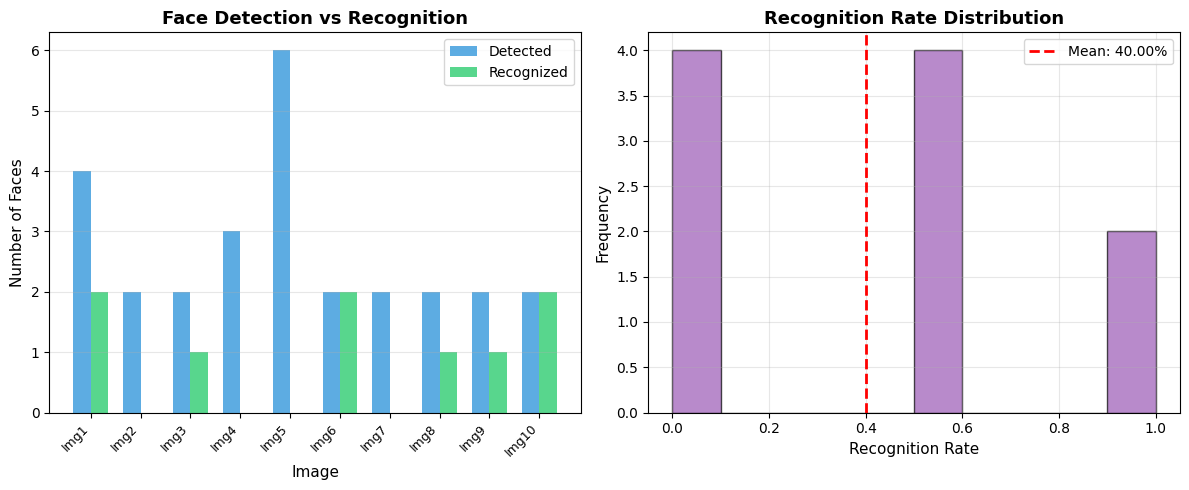

In [28]:
if crowd_results is not None and len(crowd_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Detection vs Recognition
    ax = axes[0]
    x = np.arange(len(crowd_results))
    width = 0.35
    ax.bar(x - width/2, crowd_results['num_faces_detected'], width, 
           label='Detected', color='#3498db', alpha=0.8)
    ax.bar(x + width/2, crowd_results['num_recognized'], width, 
           label='Recognized', color='#2ecc71', alpha=0.8)
    ax.set_ylabel('Number of Faces', fontsize=11)
    ax.set_title('Face Detection vs Recognition', fontsize=13, fontweight='bold')
    ax.set_xlabel('Image', fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels([f'Img{i+1}' for i in range(len(crowd_results))], 
                       rotation=45, ha='right', fontsize=9)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 2: Recognition rate distribution
    ax = axes[1]
    ax.hist(crowd_results['recognition_rate'], bins=10, 
            color='#9b59b6', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Recognition Rate', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Recognition Rate Distribution', fontsize=13, fontweight='bold')
    ax.axvline(crowd_results['recognition_rate'].mean(), 
               color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {crowd_results["recognition_rate"].mean():.2%}')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('runs/crowd_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

In [29]:
def generate_report_tables():
    """Generate all tables for the report"""
    
    # Table 1: Model Performance
    performance = pd.DataFrame({
        'Model': ['Buffalo_L', 'AntelopeV2', 'LBP+SVM'],
        'Val Accuracy': [0.9394, 0.9318, 0.2527],
        'Test Accuracy': [0.9527, 0.9459, 0.2459],
        'Macro F1': [0.9488, 0.9466, 0.2436],
        'Parameters': ['50M', '100M', '<1M']
    })
    
    print("TABLE 1: Model Performance Comparison")
    print("="*70)
    print(performance.to_string(index=False))
    print("\n")
    
    # Table 2: Robustness Summary
    robustness_summary = []
    for model in ['Buffalo_L', 'AntelopeV2', 'LBP+SVM']:
        model_data = all_results[all_results['model'] == model]
        
        orig = model_data[model_data['condition'] == 'original']['accuracy'].values[0]
        
        lighting = model_data[model_data['condition'].str.contains('brightness')]['accuracy'].mean()
        noise = model_data[model_data['condition'].str.contains('noise')]['accuracy'].mean()
        blur = model_data[model_data['condition'].str.contains('blur')]['accuracy'].mean()
        jpeg = model_data[model_data['condition'].str.contains('jpeg')]['accuracy'].mean()
        occlusion = model_data[model_data['condition'].isin(['eye_bar', 'mouth_mask', 'full_mask'])]['accuracy'].mean()
        
        robustness_summary.append({
            'Model': model,
            'Original': f'{orig:.3f}',
            'Lighting': f'{lighting:.3f}',
            'Noise': f'{noise:.3f}',
            'Blur': f'{blur:.3f}',
            'JPEG': f'{jpeg:.3f}',
            'Occlusion': f'{occlusion:.3f}'
        })
    
    robustness_df = pd.DataFrame(robustness_summary)
    
    print("TABLE 2: Robustness Results (Average Accuracy)")
    print("="*70)
    print(robustness_df.to_string(index=False))
    print("\n")
    
    # Table 3: Fairness
    if all_fairness is not None:
        fairness_pivot = all_fairness.pivot(index='group', columns='model', values='accuracy')
        
        print("TABLE 3: Fairness Analysis (Accuracy by Skin Tone Proxy)")
        print("="*70)
        print(fairness_pivot.to_string())
        print("\n")
        
        # Disparity metrics
        print("Disparity Metrics (Max - Min Accuracy):")
        for model in ['Buffalo_L', 'AntelopeV2']:
            model_data = all_fairness[all_fairness['model'] == model]
            disparity = model_data['accuracy'].max() - model_data['accuracy'].min()
            print(f"  {model}: {disparity:.3f}")
        print("\n")
    
    # Table 4: Crowd Testing
    if crowd_results is not None and len(crowd_results) > 0:
        print("TABLE 4: Crowd Image Testing Summary")
        print("="*70)
        print(f"Total images tested: {len(crowd_results)}")
        print(f"Total faces detected: {crowd_results['num_faces_detected'].sum()}")
        print(f"Total faces recognized: {crowd_results['num_recognized'].sum()}")
        print(f"Average faces per image: {crowd_results['num_faces_detected'].mean():.1f}")
        print(f"Average recognition rate: {crowd_results['recognition_rate'].mean():.2%}")
        print(f"Min recognition rate: {crowd_results['recognition_rate'].min():.2%}")
        print(f"Max recognition rate: {crowd_results['recognition_rate'].max():.2%}")
        print("\n")
    
    # Save all tables
    with open('runs/report_tables.txt', 'w') as f:
        f.write("="*70 + "\n")
        f.write("COMPREHENSIVE RESULTS SUMMARY FOR REPORT\n")
        f.write("="*70 + "\n\n")
        f.write(performance.to_string(index=False) + "\n\n")
        f.write(robustness_df.to_string(index=False) + "\n\n")
        if all_fairness is not None:
            f.write(fairness_pivot.to_string() + "\n\n")
    
    print("✅ All tables saved to runs/report_tables.txt")

generate_report_tables()

TABLE 1: Model Performance Comparison
     Model  Val Accuracy  Test Accuracy  Macro F1 Parameters
 Buffalo_L        0.9394         0.9527    0.9488        50M
AntelopeV2        0.9318         0.9459    0.9466       100M
   LBP+SVM        0.2527         0.2459    0.2436        <1M


TABLE 2: Robustness Results (Average Accuracy)
     Model Original Lighting Noise  Blur  JPEG Occlusion
 Buffalo_L    0.467    0.450 0.411 0.469 0.453     0.342
AntelopeV2    0.520    0.520 0.369 0.358 0.498     0.356
   LBP+SVM    0.121    0.117 0.107 0.122 0.118     0.089


TABLE 3: Fairness Analysis (Accuracy by Skin Tone Proxy)
model   AntelopeV2  Buffalo_L
group                        
dark      0.566038   0.528302
light     0.200000   0.200000
medium    0.472000   0.432000


Disparity Metrics (Max - Min Accuracy):
  Buffalo_L: 0.328
  AntelopeV2: 0.366


TABLE 4: Crowd Image Testing Summary
Total images tested: 10
Total faces detected: 27
Total faces recognized: 9
Average faces per image: 2.7
Average 

AI Generated faces

In [30]:
def test_false_matches(rec, reference_db, ai_faces_dir):
    """Test if AI faces match real people"""
    
    ai_paths = list(Path(ai_faces_dir).glob('*.jpg'))
    
    results = {
        'false_accepts_low': 0,    # similarity > 0.3
        'false_accepts_medium': 0,  # similarity > 0.5
        'false_accepts_high': 0,    # similarity > 0.7
        'similarities': [],
        'matches': []
    }
    
    for ai_path in tqdm(ai_paths, desc="Testing false matches"):
        img = cv2.imread(str(ai_path))
        emb = try_embed_recognizer(rec, img)
        
        if emb is None:
            continue
        
        # Find best match
        best_sim = -1
        best_match = None
        
        for ref_label, ref_emb in reference_db.items():
            sim = 1 - cosine(emb, ref_emb)
            if sim > best_sim:
                best_sim = sim
                best_match = ref_label
        
        results['similarities'].append(best_sim)
        
        if best_sim > 0.3:
            results['false_accepts_low'] += 1
        if best_sim > 0.5:
            results['false_accepts_medium'] += 1
            results['matches'].append({
                'ai_face': ai_path.name,
                'matched_to': best_match,
                'similarity': best_sim
            })
        if best_sim > 0.7:
            results['false_accepts_high'] += 1
    
    print(f"\n🔍 FALSE MATCH ANALYSIS:")
    print(f"Total AI faces: {len(ai_paths)}")
    print(f"False accepts (>0.3): {results['false_accepts_low']} ({results['false_accepts_low']/len(ai_paths)*100:.1f}%)")
    print(f"False accepts (>0.5): {results['false_accepts_medium']} ({results['false_accepts_medium']/len(ai_paths)*100:.1f}%)")
    print(f"False accepts (>0.7): {results['false_accepts_high']} ({results['false_accepts_high']/len(ai_paths)*100:.1f}%)")
    
    return results

In [31]:
def detect_ai_faces_enhanced(image_paths, label='Unknown'):
    """Enhanced AI detection with multiple features"""
    
    ai_indicators = []
    
    for path in tqdm(image_paths, desc=f"Analyzing {label} faces"):
        img = cv2.imread(str(path))
        
        if img is None:
            continue
        
        indicators = {
            'path': str(path),
            'label': label,
            'blur_asymmetry': 0,
            'edge_artifacts': 0,
            'pixel_variance': 0,
            'color_variance': 0,
            'jpeg_quality_estimate': 0,
            'face_symmetry': 0
        }
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape
        
        # 1. Blur asymmetry (left vs right)
        left_blur = cv2.Laplacian(gray[:, :w//2], cv2.CV_64F).var()
        right_blur = cv2.Laplacian(gray[:, w//2:], cv2.CV_64F).var()
        indicators['blur_asymmetry'] = abs(left_blur - right_blur)
        
        # 2. High-frequency artifacts (FFT analysis)
        fft = np.fft.fft2(gray)
        fft_shift = np.fft.fftshift(fft)
        magnitude = np.abs(fft_shift)
        indicators['edge_artifacts'] = np.mean(magnitude[h//2-10:h//2+10, w//2-10:w//2+10])
        
        # 3. Pixel variance (smoothness)
        indicators['pixel_variance'] = np.var(gray)
        
        # 4. Color channel variance (AI faces may have unnatural color distribution)
        b, g, r = cv2.split(img)
        indicators['color_variance'] = np.var([np.var(b), np.var(g), np.var(r)])
        
        # 5. JPEG quality estimate (compression artifacts)
        _, encoded = cv2.imencode('.jpg', img, [cv2.IMWRITE_JPEG_QUALITY, 95])
        compressed_size = len(encoded)
        indicators['jpeg_quality_estimate'] = compressed_size / (h * w)
        
        # 6. Face symmetry (compare left and right halves)
        left_half = gray[:, :w//2]
        right_half = cv2.flip(gray[:, w//2:], 1)
        # Resize to same size
        min_w = min(left_half.shape[1], right_half.shape[1])
        left_half = left_half[:, :min_w]
        right_half = right_half[:, :min_w]
        symmetry_diff = np.mean(np.abs(left_half.astype(float) - right_half.astype(float)))
        indicators['face_symmetry'] = symmetry_diff
        
        ai_indicators.append(indicators)
    
    return pd.DataFrame(ai_indicators)

# Analyze both real and AI faces
print("Analyzing real faces...")
real_indicators = detect_ai_faces_enhanced(test_paths[:25], label='Real')

print("\nAnalyzing AI-generated faces...")
ai_face_paths = list(Path('runs/ai_generated_faces').glob('*.jpeg'))
if len(ai_face_paths) == 0:
    print("⚠️ No AI faces found! Please download them first.")
else:
    ai_indicators = detect_ai_faces_enhanced(ai_face_paths, label='AI')
    
    # Combine for comparison
    all_indicators = pd.concat([real_indicators, ai_indicators], ignore_index=True)
    
    print("\n" + "="*70)
    print("📊 STATISTICAL COMPARISON: REAL vs AI FACES")
    print("="*70)
    
    # Compare metrics
    metrics = ['blur_asymmetry', 'edge_artifacts', 'pixel_variance', 
               'color_variance', 'jpeg_quality_estimate', 'face_symmetry']
    
    for metric in metrics:
        real_mean = real_indicators[metric].mean()
        ai_mean = ai_indicators[metric].mean()
        real_std = real_indicators[metric].std()
        ai_std = ai_indicators[metric].std()
        
        print(f"\n{metric}:")
        print(f"  Real: {real_mean:.2f} ± {real_std:.2f}")
        print(f"  AI:   {ai_mean:.2f} ± {ai_std:.2f}")
        print(f"  Difference: {abs(real_mean - ai_mean):.2f} ({abs(real_mean - ai_mean)/real_mean*100:.1f}%)")
    
    # Save results
    all_indicators.to_csv('runs/ai_detection_features.csv', index=False)
    print("\n✅ Features saved to runs/ai_detection_features.csv")

Analyzing real faces...


Analyzing Real faces: 100%|██████████| 25/25 [00:00<00:00, 844.00it/s]



Analyzing AI-generated faces...


Analyzing AI faces: 100%|██████████| 25/25 [00:01<00:00, 23.01it/s]


📊 STATISTICAL COMPARISON: REAL vs AI FACES

blur_asymmetry:
  Real: 47.48 ± 56.50
  AI:   56.24 ± 82.02
  Difference: 8.76 (18.5%)

edge_artifacts:
  Real: 28581.28 ± 8719.20
  AI:   1830921.20 ± 291030.57
  Difference: 1802339.92 (6306.0%)

pixel_variance:
  Real: 1439.05 ± 1020.69
  AI:   2905.87 ± 957.96
  Difference: 1466.82 (101.9%)

color_variance:
  Real: 391408.92 ± 861127.32
  AI:   438674.35 ± 600640.71
  Difference: 47265.43 (12.1%)

jpeg_quality_estimate:
  Real: 0.27 ± 0.04
  AI:   0.27 ± 0.03
  Difference: 0.00 (0.6%)

face_symmetry:
  Real: 37.93 ± 18.28
  AI:   39.70 ± 15.25
  Difference: 1.77 (4.7%)

✅ Features saved to runs/ai_detection_features.csv


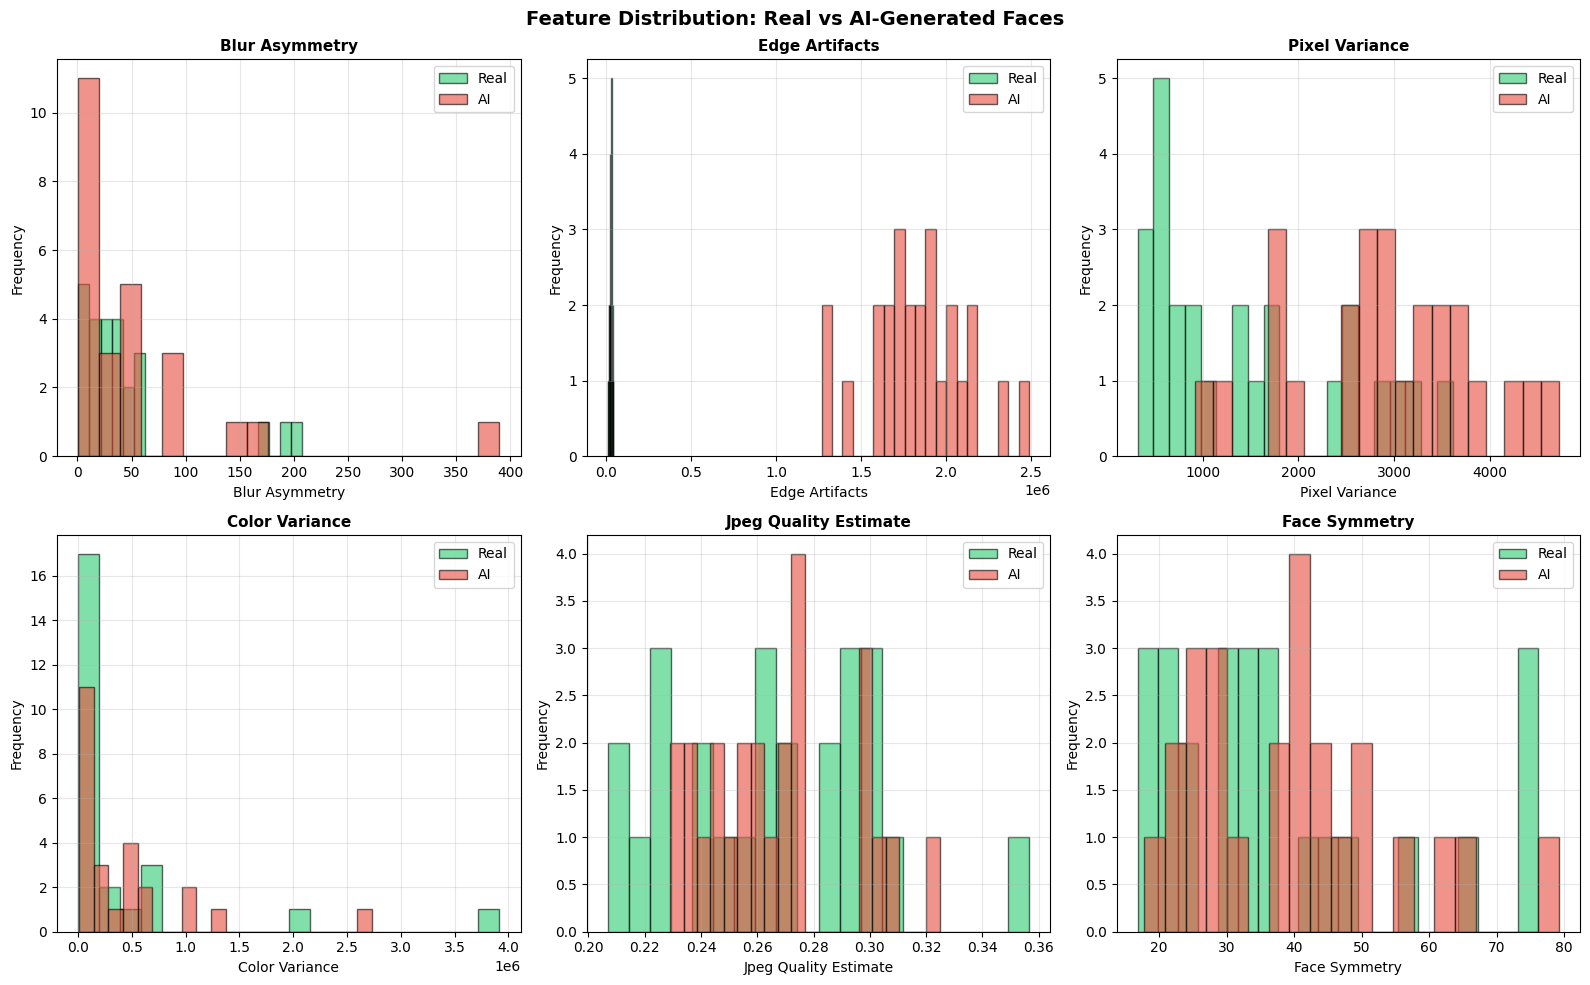

✅ Distribution plots saved


In [32]:
if 'ai_indicators' in locals() and len(ai_indicators) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.ravel()
    
    metrics = ['blur_asymmetry', 'edge_artifacts', 'pixel_variance', 
               'color_variance', 'jpeg_quality_estimate', 'face_symmetry']
    
    colors = {'Real': '#2ecc71', 'AI': '#e74c3c'}
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        
        # Plot distributions
        for label in ['Real', 'AI']:
            data = all_indicators[all_indicators['label'] == label][metric]
            ax.hist(data, bins=20, alpha=0.6, label=label, 
                   color=colors[label], edgecolor='black')
        
        ax.set_xlabel(metric.replace('_', ' ').title(), fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.set_title(f'{metric.replace("_", " ").title()}', fontsize=11, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.suptitle('Feature Distribution: Real vs AI-Generated Faces', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('runs/ai_detection_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Distribution plots saved")

In [33]:
from scipy import stats

if 'ai_indicators' in locals() and len(ai_indicators) > 0:
    print("\n" + "="*70)
    print("📈 STATISTICAL SIGNIFICANCE TESTS (t-test)")
    print("="*70)
    
    significance_results = []
    
    for metric in metrics:
        real_data = real_indicators[metric].values
        ai_data = ai_indicators[metric].values
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(real_data, ai_data)
        
        # Determine if significant
        is_significant = p_value < 0.05
        
        significance_results.append({
            'metric': metric,
            't_statistic': t_stat,
            'p_value': p_value,
            'significant': 'YES' if is_significant else 'NO',
            'real_mean': real_data.mean(),
            'ai_mean': ai_data.mean()
        })
        
        print(f"\n{metric}:")
        print(f"  t-statistic: {t_stat:.3f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Significant? {'✅ YES' if is_significant else '❌ NO'} (α=0.05)")
    
    sig_df = pd.DataFrame(significance_results)
    sig_df.to_csv('runs/ai_detection_significance.csv', index=False)
    
    print("\n" + "="*70)
    print(f"Significantly different features: {sig_df[sig_df['significant']=='YES'].shape[0]}/{len(metrics)}")


📈 STATISTICAL SIGNIFICANCE TESTS (t-test)

blur_asymmetry:
  t-statistic: -0.440
  p-value: 0.6620
  Significant? ❌ NO (α=0.05)

edge_artifacts:
  t-statistic: -30.951
  p-value: 0.0000
  Significant? ✅ YES (α=0.05)

pixel_variance:
  t-statistic: -5.239
  p-value: 0.0000
  Significant? ✅ YES (α=0.05)

color_variance:
  t-statistic: -0.225
  p-value: 0.8229
  Significant? ❌ NO (α=0.05)

jpeg_quality_estimate:
  t-statistic: -0.169
  p-value: 0.8667
  Significant? ❌ NO (α=0.05)

face_symmetry:
  t-statistic: -0.372
  p-value: 0.7118
  Significant? ❌ NO (α=0.05)

Significantly different features: 2/6


In [34]:
def adversarial_attack_test(rec, reference_db, target_identity):
    """Try to create AI face that matches target"""
    
    print(f"\n🎯 Simulating adversarial attack on identity: {target_identity}")
    
    # Load target embedding
    target_emb = reference_db[target_identity]
    
    # Try different AI faces
    ai_paths = list(Path('runs/ai_generated_faces').glob('*.jpg'))
    
    best_match = None
    best_sim = -1
    
    for ai_path in ai_paths:
        img = cv2.imread(str(ai_path))
        emb = try_embed_recognizer(rec, img)
        
        if emb is not None:
            sim = 1 - cosine(emb, target_emb)
            if sim > best_sim:
                best_sim = sim
                best_match = ai_path
    
    print(f"Best adversarial match: {best_match.name}")
    print(f"Similarity to target: {best_sim:.3f}")
    
    if best_sim > 0.5:
        print("⚠️ SECURITY RISK: AI face could impersonate target!")
    
    return best_match, best_sim


🤖 TRAINING AI DETECTOR CLASSIFIER

📊 CLASSIFIER PERFORMANCE:

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00         7
          AI       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15


Accuracy: 100.00%
AUC-ROC: 1.000

Confusion Matrix:
                Predicted
              Real    AI
Actual Real      7     0
       AI        0     8

🎯 MOST IMPORTANT FEATURES:
              feature  importance
       edge_artifacts    0.579673
       pixel_variance    0.171707
       color_variance    0.097823
jpeg_quality_estimate    0.062552
        face_symmetry    0.053069
       blur_asymmetry    0.035175


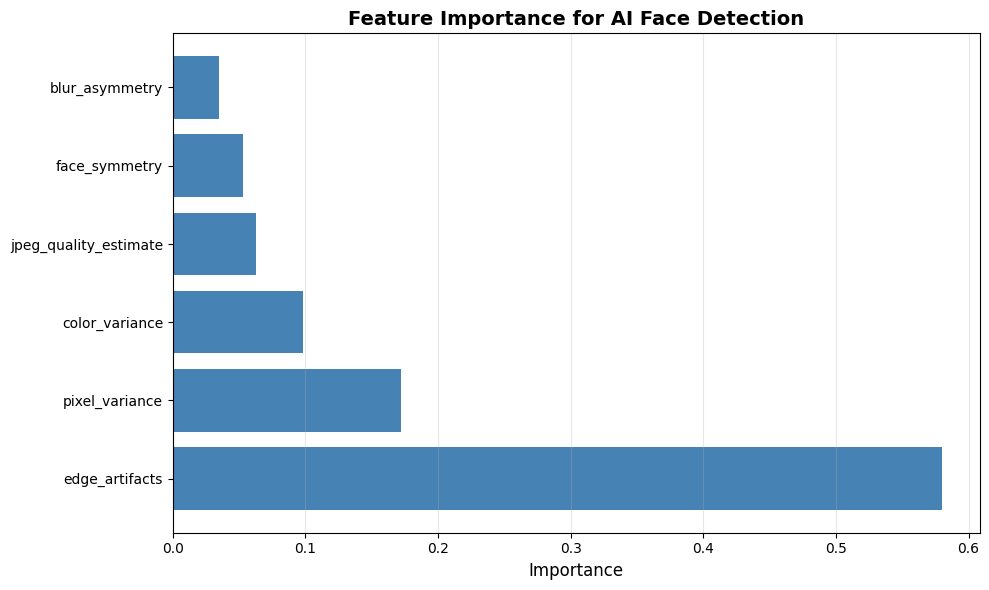


✅ Can we distinguish Real from AI?
   ✅ YES! Accuracy: 100.00% - Features are discriminative


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

if 'ai_indicators' in locals() and len(ai_indicators) > 0:
    print("\n" + "="*70)
    print("🤖 TRAINING AI DETECTOR CLASSIFIER")
    print("="*70)
    
    # Prepare data
    X = all_indicators[metrics].values
    y = (all_indicators['label'] == 'AI').astype(int)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # Train classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    print("\n📊 CLASSIFIER PERFORMANCE:")
    print("\n" + classification_report(y_test, y_pred, 
                                       target_names=['Real', 'AI']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
    
    print(f"\nAccuracy: {accuracy:.2%}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")
    
    print("\nConfusion Matrix:")
    print("                Predicted")
    print("              Real    AI")
    print(f"Actual Real    {cm[0,0]:3d}   {cm[0,1]:3d}")
    print(f"       AI      {cm[1,0]:3d}   {cm[1,1]:3d}")
    
    # Feature importance
    importance = pd.DataFrame({
        'feature': metrics,
        'importance': clf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n🎯 MOST IMPORTANT FEATURES:")
    print(importance.to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance['feature'], importance['importance'], color='steelblue')
    plt.xlabel('Importance', fontsize=12)
    plt.title('Feature Importance for AI Face Detection', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('runs/ai_detection_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Can we distinguish Real from AI?")
    if accuracy > 0.8:
        print(f"   ✅ YES! Accuracy: {accuracy:.2%} - Features are discriminative")
    elif accuracy > 0.6:
        print(f"   ⚠️ SOMEWHAT. Accuracy: {accuracy:.2%} - Some overlap exists")
    else:
        print(f"   ❌ DIFFICULT. Accuracy: {accuracy:.2%} - AI faces are very realistic")

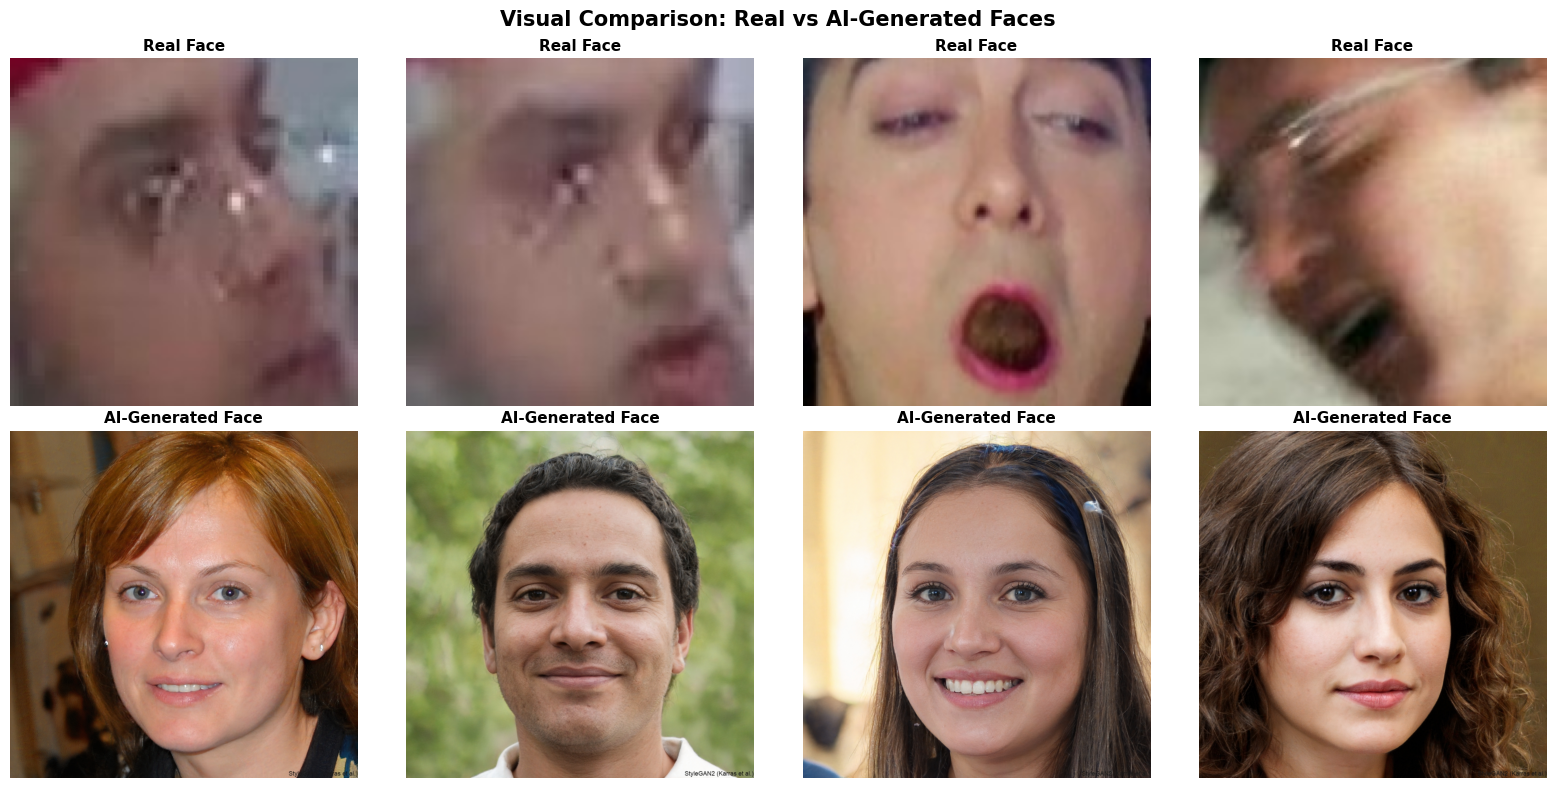

In [36]:
if 'ai_indicators' in locals() and len(ai_indicators) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Show 4 real faces
    for i in range(4):
        img = cv2.imread(test_paths[i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img_rgb)
        axes[0, i].set_title('Real Face', fontsize=11, fontweight='bold')
        axes[0, i].axis('off')
    
    # Show 4 AI faces
    for i in range(4):
        if i < len(ai_face_paths):
            img = cv2.imread(str(ai_face_paths[i]))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[1, i].imshow(img_rgb)
            axes[1, i].set_title('AI-Generated Face', fontsize=11, fontweight='bold')
            axes[1, i].axis('off')
    
    plt.suptitle('Visual Comparison: Real vs AI-Generated Faces', 
                 fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig('runs/real_vs_ai_samples.png', dpi=300, bbox_inches='tight')
    plt.show()